# population-inference
notebook for running vectorised inference over a population of hares or emus

In [2]:
#stock imports
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca import emulator
from scripts.pitchfuncs_ultra_pca import ultra_ns_vector_nice
import ultranest.mlfriends


2024-06-18 17:00:31.296529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 17:00:31.296558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 17:00:31.297530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 17:00:31.302309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 17:00:31.842849: W tensorflow/compiler/tf2

## import neural network

In [3]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


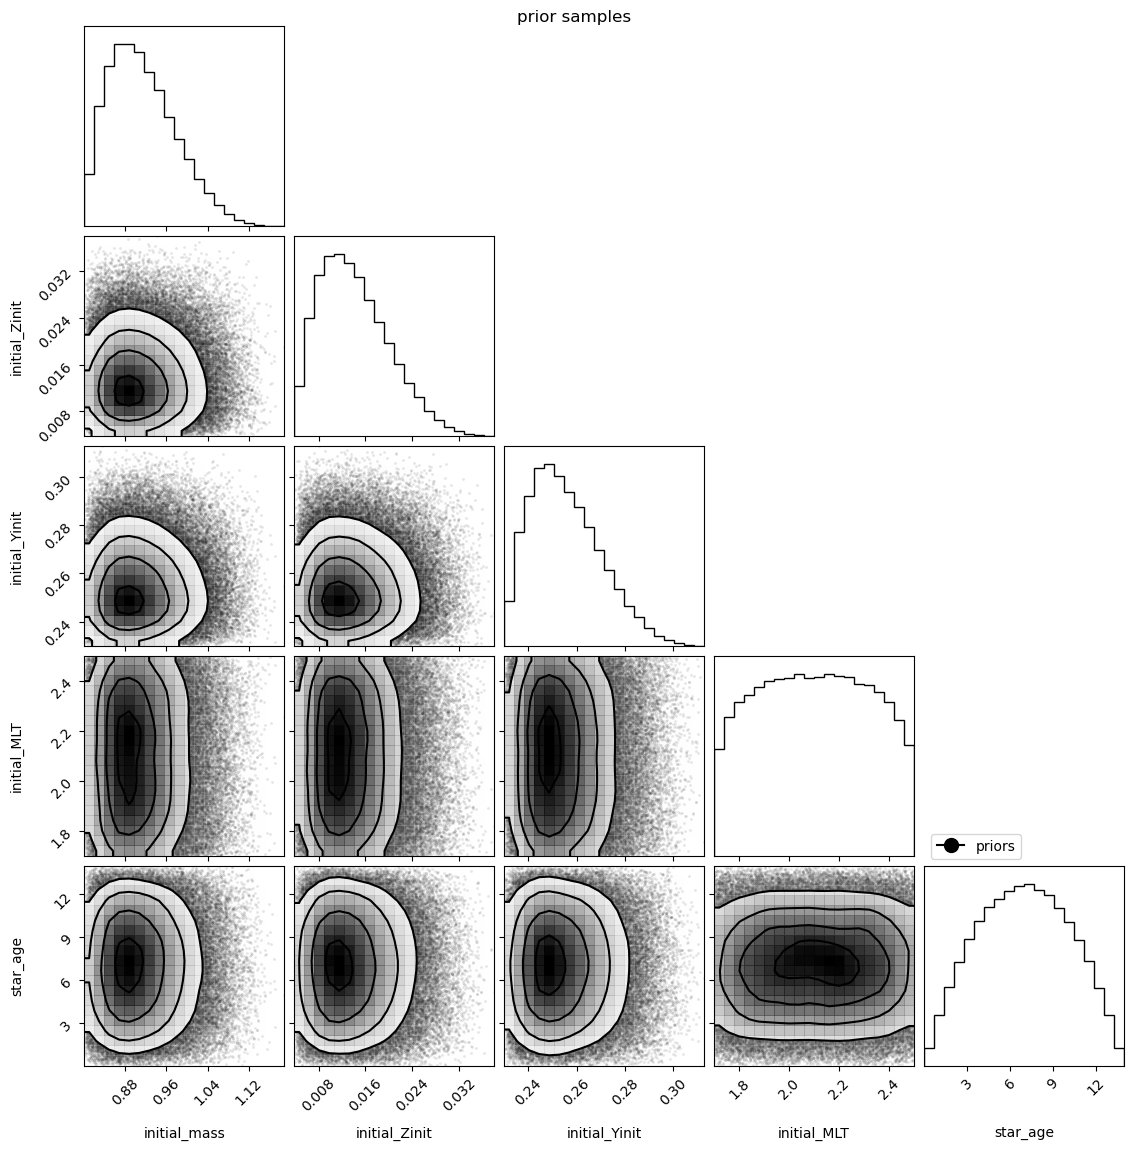

In [4]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.0038, 0.04, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.23, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0, 14, a=2, b=2)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [ ]:
%%time

with open("pitchfork/emulator_cov.pkl", 'rb') as fp:
     sigma_nn = pickle.load(fp)

ndraw_min=2**14
ndraw_max=2**16

obs_idx = 2
for hare_idx in range(2,3):
    path = f'form/hare{hare_idx}/obs{obs_idx}/'
    hare_observed = pd.read_json(path+f'obs{obs_idx}.json')
    hare_uncs = pd.read_json(path+'uncs.json')
    hare_uncs_array = hare_uncs.values[0]

    n_min = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[0].replace('nu_0_',''))
    n_max = int(hare_uncs.drop(['calc_effective_T', 'luminosity', 'star_feh'], axis=1).columns[-1].replace('nu_0_',''))

    sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
    sigma_nn_mask[:3] = True
    sigma_nn_mask[n_min-3:n_max-2] = True

    sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

    sigma_obs = (hare_uncs_array*hare_uncs_array)*(np.identity(len(hare_uncs_array)))

    sigma = sigma_nn_cropped + sigma_obs

    sigma_inv = np.linalg.inv(sigma)

    _, log_sigma_det = np.linalg.slogdet(sigma)
    
    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
    
    sampler = ultra_ns_vector_nice(priors=priors, observed_vals=hare_observed[outputs].values[0], pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
    results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=.05)
    with open(path+'/samples.pkl', 'wb') as fp:
        pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

    sampler.cleanup()
    del results

[ultranest] Sampling 400 live points from prior ...


2024-06-18 17:00:35.506266: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
